In [273]:
import numpy as np
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import sem


### Exclusion Criteria
 - Accuracy: 70 % (17/24 correct)
 - RT: Exclude trial if < 250 ms or > 2s
    

In [274]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    """
    
    exclude = []
    
    #checks if path is a file 
    isFile = os.path.isfile(datafolder)
    print(isFile)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                # do NOT include subject IDs that have been flagged 
                subjID = df.subjID.unique()[0]
                if subjID not in exclude:
                    data.append(df)

                
        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
    
    print('Number of participants before cleaning: ', len(input_frame.subjID.unique()))

 
    return input_frame

In [275]:
# data_path = '/Users/pmahableshwarkar/Documents/object_scene_scaling/v6_b1_data.csv'
# data_path = '/Users/prachimahableshwarkar/Documents/GW/OSS/v6_b1_data.csv'
data_path = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/OSS_MTurk/data'

In [276]:
input_data = combineCSVs(data_path)

False
Number of participants before cleaning:  67


In [277]:
# input_data

In [278]:
num_trials = 16

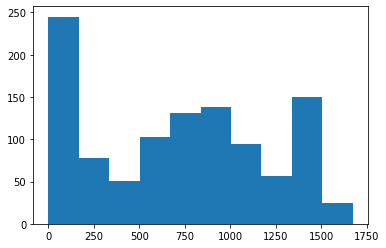

In [279]:
plt.hist(list(input_data['RT']))
plt.show();

In [280]:
def cleanbyPracticeTries(df, num_allowed_tries):
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_practice_tries = cleaned_subj_df.pracTries.unique()[0]
        
        if subj_num_practice_tries > num_allowed_tries:
            print(subj_num_practice_tries)
            remove.append(subj)
        else:  
            df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
            
    print('Number of participants with more than ' + str(num_allowed_tries) + ' practice tries:', len(remove))
    
    return df2
    

In [281]:
pracTries_cleaned_data = cleanbyPracticeTries(input_data, 3)

9
22
10
4
10
7
6
5
12
4
4
5
15
9
10
13
6
8
4
4
16
4
6
4
Number of participants with more than 3 practice tries: 24


In [282]:
len(pracTries_cleaned_data.subjID.unique())

43

In [286]:
def RT_Cleaning(df, outlier_range, num_trials):
    """
    Remove trials where trial RT is outside of the defined outlier range 
    
    Returns:
        dataframe with outlier RT trials removed
        list of all RTs 
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    print(len(all_subjIDs))
    
    remove = []
    df2_list = []
    total_RT_outliers = 0
    RT_outliers = []
    total = 0
    list_trialRT = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 

        for idx, row in subj_df.iterrows():
            total += 1
            RT = row["RT"]
            list_trialRT.append(RT)
            if RT < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
                RT_outliers.append(RT)
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
                RT_outliers.append(RT)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print(len(df2.subjID.unique()))
                
    return df2, list_trialRT, RT_outliers

In [287]:
RT_cleaned_data, trialRTs_distribution, RT_outliers = RT_Cleaning(pracTries_cleaned_data, [250, 3000], num_trials)


43
38


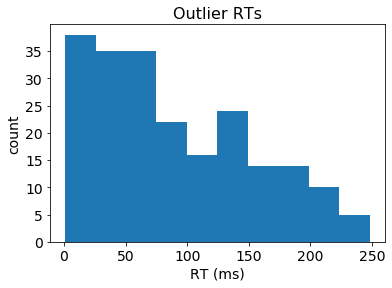

In [294]:
plt.hist(RT_outliers)
plt.ylabel('count', fontsize=14)
plt.xlabel('RT (ms)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Outlier RTs', fontsize=16)
plt.show()

In [295]:
len(RT_cleaned_data.subjID.unique())

38

In [296]:
# pracTries_cleaned_data.subjID.unique(), RT_cleaned_data.subjID.unique()

In [297]:
np.sum(np.array(RT_cleaned_data['accuracy']))/len(np.array(RT_cleaned_data['accuracy']))

0.6357894736842106

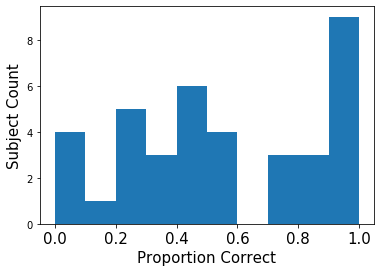

In [298]:
subj_accs = []
for subj in RT_cleaned_data.subjID.unique():
    subj_df = RT_cleaned_data.loc[RT_cleaned_data['subjID']==subj]
    subj_PC = np.sum(np.array(subj_df['accuracy']))/len(np.array(subj_df['accuracy']))
    subj_accs.append(subj_PC)
    
plt.hist(subj_accs)
# plt.yticks(np.arange(0,3,1), fontsize=15)
plt.xticks(np.arange(0,1.2,0.2), fontsize=15)
plt.xlabel('Proportion Correct', fontsize=15)
plt.ylabel('Subject Count', fontsize=15)
plt.show();
# subj_accs

In [299]:
def Accuracy_Cleaning(df, accuracy_threshold, num_trials):
    """    
    Remove participants with overall accuracy below the accuracy threshold (e.g. 0.7)
    
    Returns:
        data of participants that passed the accuracy threshold 
        list of the number of correct trials each participant got
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    list_trials_correct = []
    # number of participants where exclusion is because all responses were 'none'
    c = 0
    
    for subj in all_subjIDs:
        keypresses = []

        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_correct_trials = 0
        for idx, row in subj_df.iterrows():
            trial_acc = row['accuracy']
            if trial_acc == 1:
                subj_num_correct_trials += 1
            else:
                keypresses.append(row['keyPress'])
                
        subj_acc = subj_num_correct_trials/num_trials
                
        # minimum number of trials correct the participant must have to be included
        if subj_acc < accuracy_threshold:
            remove.append(subj)
#             print(len([x for x in keypresses if x == 'none']))
            if len([x for x in keypresses if x == 'none']) >= 4:
                c += 1
        
        list_trials_correct.append(subj_num_correct_trials)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    
    print("Number of Participants with accuracy below 70%: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
                
    print('Number of participants that did not respond for 4 or more trials:', c)
    
    print('Number of participants left: ', len(df2.subjID.unique()))
                
    return df2, list_trials_correct, keypresses

In [300]:
Accuracy_cleaned_data, correct_trials_distribution, keypresses = Accuracy_Cleaning(RT_cleaned_data, 0.7, num_trials)


Number of Participants with accuracy below 70%:  24
Number of participants that did not respond for 5 or more trials: 8
Number of participants left:  14


In [301]:
len(Accuracy_cleaned_data.subjID.unique())

14

In [302]:
np.sum(np.array(Accuracy_cleaned_data['accuracy']))/len(np.array(Accuracy_cleaned_data['accuracy']))

0.9151785714285714

In [303]:
# plt.figure()
# plt.hist((np.array(correct_trials_distribution))/num_trials, color='darkblue', bins=20)
# plt.yticks(np.arange(1,3))
# plt.title('Accuracy Distribution', fontsize=16)
# plt.xlabel('Percent Correct', fontsize=12)
# plt.ylabel('Number of participants', fontsize=12)
# plt.show()

In [304]:
final_data = Accuracy_cleaned_data.copy(deep=True)
len(Accuracy_cleaned_data.subjID.unique())

14

In [305]:
# Accuracy_cleaned_data['scene1ZoomName']

### Create df with 'misscaled' column for JASP analysis

zo + objSize small --> misscaled 

zi + objSize large --> misscaled

zo + objSize large --> scaled 

zi + objSize small --> scaled

In [306]:
def get_misscaled_trials(df):
    """
    args:
        df  
    returns:
        array of misscaled/scaled
    """
    misscaled_col = []
    
    for idx, row in df.iterrows():
        if row['scene1ZoomName'] == 'zo' and row['objectSize']=='small':
            misscaled_col.append('misscaled')

        if row['scene1ZoomName'] == 'zi' and row['objectSize']=='large':
            misscaled_col.append('misscaled')
            
        if row['scene1ZoomName'] == 'zo' and row['objectSize']=='large':
            misscaled_col.append('scaled')

        if row['scene1ZoomName'] == 'zi' and row['objectSize']=='small':
            misscaled_col.append('scaled')
            
            
            
    
    return np.array(misscaled_col)

In [307]:
misscaled_column = get_misscaled_trials(final_data)

# # add misscaled column to dataframe 
final_data.insert(14, "misscaled", misscaled_column)


In [308]:
final_data.to_csv('e2v2_data.csv', index=False)

In [309]:
len(final_data.subjID.unique())

14

## Accuracy


add error bars
- overall accuracy per subj in each condition 

In [310]:
# data split by object-scene size congruency aka scene zoom 

zo_df = final_data.loc[final_data['scene1ZoomName']=='zo']
zi_df = final_data.loc[final_data['scene1ZoomName']=='zi']

zo_acc = np.sum(np.array(zo_df['accuracy']))/len(np.array(zo_df['accuracy']))
zi_acc = np.sum(np.array(zi_df['accuracy']))/len(np.array(zi_df['accuracy']))

zo_acc, zi_acc

(0.9464285714285714, 0.8839285714285714)

In [311]:
misscaled_zo = zo_df.loc[zo_df['misscaled'] =='misscaled'] 
misscaled_zi = zi_df.loc[zi_df['misscaled'] =='misscaled']
misscaled = misscaled_zo.append(misscaled_zi)

scaled_zo = zo_df.loc[zo_df['misscaled'] =='scaled'] 
scaled_zi = zi_df.loc[zi_df['misscaled'] =='scaled']
scaled = scaled_zo.append(scaled_zi)

misscaled_acc = np.sum(np.array(misscaled['accuracy']))/len(np.array(misscaled['accuracy']))
scaled_acc = np.sum(np.array(scaled['accuracy']))/len(np.array(scaled['accuracy']))

misscaled_acc, scaled_acc

(0.9285714285714286, 0.9017857142857143)

In [312]:
# object scene semantic congruency 
# var = objectScene1SemanticCongruency
# acc = np.sum(np.array(misscaled_zo_objSemCong['accuracy']))/len(np.array(misscaled_zo_objSemCong['accuracy']))

misscaled_zo_objSemCong = misscaled_zo.loc[misscaled_zo["objectScene1SemanticCongruency"]==1]
misscaled_zo_objSemIncong = misscaled_zo.loc[misscaled_zo["objectScene1SemanticCongruency"]==0]

misscaled_zo_objSemCong_acc = np.sum(np.array(misscaled_zo_objSemCong['accuracy']))/len(np.array(misscaled_zo_objSemCong['accuracy']))
misscaled_zo_objSemIncong_acc =np.sum(np.array(misscaled_zo_objSemIncong['accuracy']))/len(np.array(misscaled_zo_objSemIncong['accuracy']))

misscaled_zo_objSemCong_sem = np.std(np.array(misscaled_zo_objSemCong['accuracy']))/np.sqrt(len(np.array(misscaled_zo_objSemCong['accuracy'])))
misscaled_zo_objSemIncong_sem = np.std(np.array(misscaled_zo_objSemIncong['accuracy']))/np.sqrt(len(np.array(misscaled_zo_objSemIncong['accuracy'])))


misscaled_zi_objSemCong = misscaled_zi.loc[misscaled_zi["objectScene1SemanticCongruency"]==1]
misscaled_zi_objSemIncong = misscaled_zi.loc[misscaled_zi["objectScene1SemanticCongruency"]==0]

misscaled_zi_objSemCong_acc = np.sum(np.array(misscaled_zi_objSemCong['accuracy']))/len(np.array(misscaled_zi_objSemCong['accuracy']))
misscaled_zi_objSemIncong_acc = np.sum(np.array(misscaled_zi_objSemIncong['accuracy']))/len(np.array(misscaled_zi_objSemIncong['accuracy']))

misscaled_zi_objSemCong_sem = np.std(np.array(misscaled_zi_objSemCong['accuracy']))/np.sqrt(len(np.array(misscaled_zi_objSemCong['accuracy'])))
misscaled_zi_objSemIncong_sem = np.std(np.array(misscaled_zi_objSemIncong['accuracy']))/np.sqrt(len(np.array(misscaled_zi_objSemIncong['accuracy'])))

# scaled
scaled_zo_objSemCong = scaled_zo.loc[scaled_zo["objectScene1SemanticCongruency"]==1]
scaled_zo_objSemIncong = scaled_zo.loc[scaled_zo["objectScene1SemanticCongruency"]==0]

scaled_zo_objSemCong_acc = np.sum(np.array(scaled_zo_objSemCong['accuracy']))/len(np.array(scaled_zo_objSemCong['accuracy']))
scaled_zo_objSemIncong_acc =np.sum(np.array(scaled_zo_objSemIncong['accuracy']))/len(np.array(scaled_zo_objSemIncong['accuracy']))

scaled_zo_objSemCong_sem = np.std(np.array(scaled_zo_objSemCong['accuracy']))/np.sqrt(len(np.array(scaled_zo_objSemCong['accuracy'])))
scaled_zo_objSemIncong_sem = np.std(np.array(scaled_zo_objSemIncong['accuracy']))/np.sqrt(len(np.array(scaled_zo_objSemIncong['accuracy'])))


scaled_zi_objSemCong = scaled_zi.loc[scaled_zi["objectScene1SemanticCongruency"]==1]
scaled_zi_objSemIncong = scaled_zi.loc[scaled_zi["objectScene1SemanticCongruency"]==0]

scaled_zi_objSemCong_acc = np.sum(np.array(scaled_zi_objSemCong['accuracy']))/len(np.array(scaled_zi_objSemCong['accuracy']))
scaled_zi_objSemIncong_acc = np.sum(np.array(scaled_zi_objSemIncong['accuracy']))/len(np.array(scaled_zi_objSemIncong['accuracy']))

scaled_zi_objSemCong_sem = np.std(np.array(scaled_zi_objSemCong['accuracy']))/np.sqrt(len(np.array(scaled_zi_objSemCong['accuracy'])))
scaled_zi_objSemIncong_sem = np.std(np.array(scaled_zi_objSemIncong['accuracy']))/np.sqrt(len(np.array(scaled_zi_objSemIncong['accuracy'])))

In [313]:
# dfs: objSemCong --> scene2SemCong(0,1)
ms_zo_objSemCong_s2cong = misscaled_zo_objSemCong.loc[misscaled_zo_objSemCong["scene2SemCong"]==1]
ms_zo_objSemCong_s2incong = misscaled_zo_objSemCong.loc[misscaled_zo_objSemCong["scene2SemCong"]==0]
ms_zi_objSemCong_s2cong = misscaled_zi_objSemCong.loc[misscaled_zi_objSemCong["scene2SemCong"]==1]
ms_zi_objSemCong_s2incong = misscaled_zi_objSemCong.loc[misscaled_zi_objSemCong["scene2SemCong"]==0]

s_zo_objSemCong_s2cong = scaled_zo_objSemCong.loc[scaled_zo_objSemCong["scene2SemCong"]==1]
s_zo_objSemCong_s2incong = scaled_zo_objSemCong.loc[scaled_zo_objSemCong["scene2SemCong"]==0]
s_zi_objSemCong_s2cong = scaled_zi_objSemCong.loc[scaled_zi_objSemCong["scene2SemCong"]==1]
s_zi_objSemCong_s2incong = scaled_zi_objSemCong.loc[scaled_zi_objSemCong["scene2SemCong"]==0]

# accuracy 
ms_zo_objSemCong_s2cong_acc = np.sum(np.array(ms_zo_objSemCong_s2cong['accuracy']))/len(np.array(ms_zo_objSemCong_s2cong['accuracy']))
ms_zo_objSemCong_s2incong_acc = np.sum(np.array(ms_zo_objSemCong_s2incong['accuracy']))/len(np.array(ms_zo_objSemCong_s2incong['accuracy']))
ms_zi_objSemCong_s2cong_acc = np.sum(np.array(ms_zi_objSemCong_s2cong['accuracy']))/len(np.array(ms_zi_objSemCong_s2cong['accuracy']))
ms_zi_objSemCong_s2incong_acc = np.sum(np.array(ms_zi_objSemCong_s2incong['accuracy']))/len(np.array(ms_zi_objSemCong_s2incong['accuracy']))

s_zo_objSemCong_s2cong_acc = np.sum(np.array(s_zo_objSemCong_s2cong['accuracy']))/len(np.array(s_zo_objSemCong_s2cong['accuracy']))
s_zo_objSemCong_s2incong_acc = np.sum(np.array(s_zo_objSemCong_s2incong['accuracy']))/len(np.array(s_zo_objSemCong_s2incong['accuracy']))
s_zi_objSemCong_s2cong_acc = np.sum(np.array(s_zi_objSemCong_s2cong['accuracy']))/len(np.array(s_zi_objSemCong_s2cong['accuracy']))
s_zi_objSemCong_s2incong_acc = np.sum(np.array(s_zi_objSemCong_s2incong['accuracy']))/len(np.array(s_zi_objSemCong_s2incong['accuracy']))

# sem
ms_zo_objSemCong_s2cong_sem = np.std(np.array(ms_zo_objSemCong_s2cong['accuracy']))/np.sqrt(len(np.array(ms_zo_objSemCong_s2cong['accuracy'])))
ms_zo_objSemCong_s2incong_sem = np.std(np.array(ms_zo_objSemCong_s2incong['accuracy']))/np.sqrt(len(np.array(ms_zo_objSemCong_s2incong['accuracy'])))
ms_zi_objSemCong_s2cong_sem = np.std(np.array(ms_zi_objSemCong_s2cong['accuracy']))/np.sqrt(len(np.array(ms_zi_objSemCong_s2cong['accuracy'])))
ms_zi_objSemCong_s2incong_sem = np.std(np.array(ms_zi_objSemCong_s2incong['accuracy']))/np.sqrt(len(np.array(ms_zi_objSemCong_s2incong['accuracy'])))

s_zo_objSemCong_s2cong_sem = np.std(np.array(s_zo_objSemCong_s2cong['accuracy']))/np.sqrt(len(np.array(s_zo_objSemCong_s2cong['accuracy'])))
s_zo_objSemCong_s2incong_sem = np.std(np.array(s_zo_objSemCong_s2incong['accuracy']))/np.sqrt(len(np.array(s_zo_objSemCong_s2incong['accuracy'])))
s_zi_objSemCong_s2cong_sem = np.std(np.array(s_zi_objSemCong_s2cong['accuracy']))/np.sqrt(len(np.array(s_zi_objSemCong_s2cong['accuracy'])))
s_zi_objSemCong_s2incong_sem = np.std(np.array(s_zi_objSemCong_s2incong['accuracy']))/np.sqrt(len(np.array(s_zi_objSemCong_s2incong['accuracy'])))

In [326]:
# dfs: objSemIncong --> scene2SemCong(0,1)
ms_zo_objSemIncong_s2cong = misscaled_zo_objSemIncong.loc[misscaled_zo_objSemIncong["scene2SemCong"]==1]
ms_zi_objSemIncong_s2cong = misscaled_zi_objSemIncong.loc[misscaled_zi_objSemIncong["scene2SemCong"]==1]
ms_zi_objSemIncong_s2incong = misscaled_zi_objSemIncong.loc[misscaled_zi_objSemIncong["scene2SemCong"]==0]

s_zo_objSemIncong_s2cong = scaled_zo_objSemIncong.loc[scaled_zo_objSemIncong["scene2SemCong"]==1]
s_zo_objSemIncong_s2incong = scaled_zo_objSemIncong.loc[scaled_zo_objSemIncong["scene2SemCong"]==0]
s_zi_objSemIncong_s2cong = scaled_zi_objSemIncong.loc[scaled_zi_objSemIncong["scene2SemCong"]==1]
s_zi_objSemIncong_s2incong = scaled_zi_objSemIncong.loc[scaled_zi_objSemIncong["scene2SemCong"]==0]

# accuracy 
ms_zo_objSemIncong_s2cong_acc = np.sum(np.array(ms_zo_objSemIncong_s2cong['accuracy']))/len(np.array(ms_zo_objSemIncong_s2cong['accuracy']))
ms_zo_objSemIncong_s2incong_acc = np.sum(np.array(ms_zo_objSemIncong_s2incong['accuracy']))/len(np.array(ms_zo_objSemIncong_s2incong['accuracy']))
ms_zi_objSemIncong_s2cong_acc = np.sum(np.array(ms_zi_objSemIncong_s2cong['accuracy']))/len(np.array(ms_zi_objSemIncong_s2cong['accuracy']))
ms_zi_objSemIncong_s2incong_acc = np.sum(np.array(ms_zi_objSemIncong_s2incong['accuracy']))/len(np.array(ms_zi_objSemIncong_s2incong['accuracy']))

s_zo_objSemIncong_s2cong_acc = np.sum(np.array(s_zo_objSemIncong_s2cong['accuracy']))/len(np.array(s_zo_objSemIncong_s2cong['accuracy']))
s_zo_objSemIncong_s2incong_acc = np.sum(np.array(s_zo_objSemIncong_s2incong['accuracy']))/len(np.array(s_zo_objSemIncong_s2incong['accuracy']))
s_zi_objSemIncong_s2cong_acc = np.sum(np.array(s_zi_objSemIncong_s2cong['accuracy']))/len(np.array(s_zi_objSemIncong_s2cong['accuracy']))
s_zi_objSemIncong_s2incong_acc = np.sum(np.array(s_zi_objSemIncong_s2incong['accuracy']))/len(np.array(s_zi_objSemIncong_s2incong['accuracy']))

# sem
ms_zo_objSemIncong_s2cong_sem = sem(np.array(ms_zo_objSemIncong_s2cong['accuracy']))
ms_zo_objSemIncong_s2incong_sem = sem(np.array(ms_zo_objSemIncong_s2incong['accuracy']))
ms_zi_objSemIncong_s2cong_sem = sem(np.array(ms_zi_objSemIncong_s2cong['accuracy']))
ms_zi_objSemIncong_s2incong_sem = sem(np.array(ms_zi_objSemIncong_s2incong['accuracy']))
print(np.array(ms_zo_objSemIncong_s2incong['accuracy']), np.sum(np.array(ms_zo_objSemIncong_s2incong['accuracy']))/len(np.array(ms_zo_objSemIncong_s2incong['accuracy'])),ms_zo_objSemIncong_s2incong_sem)

# ms_zo_objSemIncong_s2cong_sem = np.std(np.array(ms_zo_objSemIncong_s2cong['accuracy']))/np.sqrt(len(np.array(ms_zo_objSemIncong_s2cong['accuracy'])))
# ms_zo_objSemIncong_s2incong_sem = np.std(np.array(ms_zo_objSemIncong_s2incong['accuracy']))/np.sqrt(len(np.array(ms_zo_objSemIncong_s2incong['accuracy'])))
# ms_zi_objSemIncong_s2cong_sem = np.std(np.array(ms_zi_objSemIncong_s2cong['accuracy']))/np.sqrt(len(np.array(ms_zi_objSemIncong_s2cong['accuracy'])))
# ms_zi_objSemIncong_s2incong_sem = np.std(np.array(ms_zi_objSemIncong_s2incong['accuracy']))/np.sqrt(len(np.array(ms_zi_objSemIncong_s2incong['accuracy'])))

s_zo_objSemIncong_s2cong_sem = np.std(np.array(s_zo_objSemIncong_s2cong['accuracy']))/np.sqrt(len(np.array(s_zo_objSemIncong_s2cong['accuracy'])))
s_zo_objSemIncong_s2incong_sem = np.std(np.array(s_zo_objSemIncong_s2incong['accuracy']))/np.sqrt(len(np.array(s_zo_objSemIncong_s2incong['accuracy'])))
s_zi_objSemIncong_s2cong_sem = np.std(np.array(s_zi_objSemIncong_s2cong['accuracy']))/np.sqrt(len(np.array(s_zi_objSemIncong_s2cong['accuracy'])))
s_zi_objSemIncong_s2incong_sem = np.std(np.array(s_zi_objSemIncong_s2incong['accuracy']))/np.sqrt(len(np.array(s_zi_objSemIncong_s2incong['accuracy'])))

[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1] 0.9473684210526315 0.05263157894736841


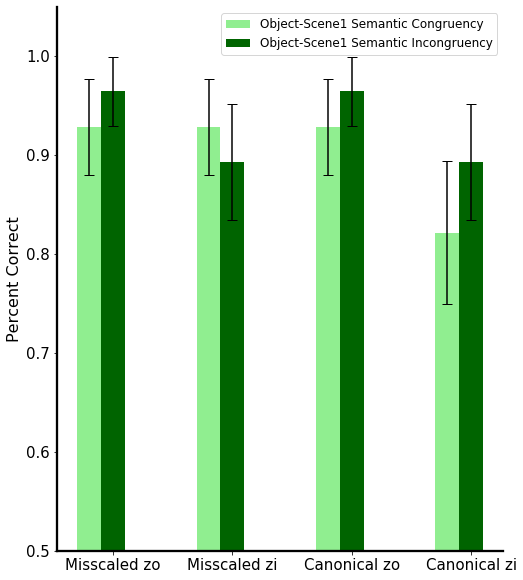

In [327]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)
#                                          Misscaled                                               Scaled
#                                zo                          zi                         zo                       zi
Acc_objSemCong =   [misscaled_zo_objSemCong_acc, misscaled_zi_objSemCong_acc, scaled_zo_objSemCong_acc, scaled_zi_objSemCong_acc]
yerr_objSemCong =  [misscaled_zo_objSemCong_sem, misscaled_zi_objSemCong_sem, scaled_zo_objSemCong_sem, scaled_zi_objSemCong_sem]

Acc_objSemIncong =   [misscaled_zo_objSemIncong_acc, misscaled_zi_objSemIncong_acc, scaled_zo_objSemIncong_acc, scaled_zi_objSemIncong_acc]
yerr_objSemIncong =  [misscaled_zo_objSemIncong_sem, misscaled_zi_objSemIncong_sem, scaled_zo_objSemIncong_sem, scaled_zi_objSemIncong_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, Acc_objSemCong, width, color='lightgreen', label='Object-Scene1 Semantic Congruency', yerr=yerr_objSemCong, capsize=5)
plt.bar(x, Acc_objSemIncong, width, color='darkgreen', label='Object-Scene1 Semantic Incongruency', yerr=yerr_objSemIncong, capsize=5)
plt.xticks(x, ['Misscaled zo', 'Misscaled zi', 'Canonical zo', 'Canonical zi'], fontsize='15')
plt.ylim(0.50)
plt.yticks(fontsize=15) 
plt.ylabel("Percent Correct", fontsize=16)
plt.legend(loc=1, fontsize=12)
plt.show()

In [328]:
ms_zo_objSemIncong_s2incong_acc

0.9473684210526315

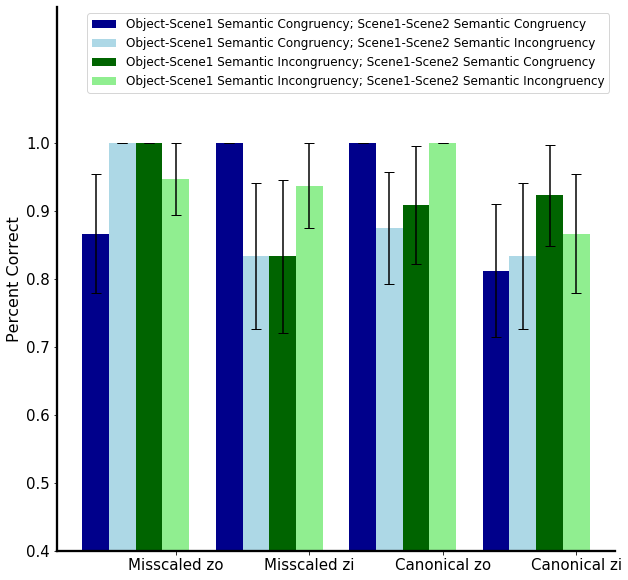

Blue colors: Object-Scene1 Semantic Congruency
Green colors: Object-Scene1 Semantic Incongruency
Dark colors: Scene1-Scene2 Semantic Congruency
Light colors: Scene1-Scene2 Semantic Incongruency


In [348]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)
#                                          Misscaled                                               Scaled
#                                zo                          zi                         zo                       zi
# Acc_objSemCong =   [misscaled_zo_objSemCong_acc, misscaled_zi_objSemCong_acc, scaled_zo_objSemCong_acc, scaled_zi_objSemCong_acc]
# yerr_objSemCong =  [misscaled_zo_objSemCong_sem, misscaled_zi_objSemCong_sem, scaled_zo_objSemCong_sem, scaled_zi_objSemCong_sem]

# Acc_objSemIncong =   [misscaled_zo_objSemIncong_acc, misscaled_zi_objSemIncong_acc, scaled_zo_objSemIncong_acc, scaled_zi_objSemIncong_acc]
# yerr_objSemIncong =  [misscaled_zo_objSemIncong_sem, misscaled_zi_objSemIncong_sem, scaled_zo_objSemIncong_sem, scaled_zi_objSemIncong_sem]

#                                                  Misscaled                                                       Scaled
#                                      zo                             zi                             zo                             zi
Acc_objSemCong_s2cong =   [ms_zo_objSemCong_s2cong_acc,   ms_zi_objSemCong_s2cong_acc,   s_zo_objSemCong_s2cong_acc,    s_zi_objSemCong_s2cong_acc]
yerr_objSemCong_s2cong =  [ms_zo_objSemCong_s2cong_sem,   ms_zi_objSemCong_s2cong_sem,   s_zo_objSemCong_s2cong_sem,    s_zi_objSemCong_s2cong_sem]

Acc_objSemCong_s2incong = [ms_zo_objSemCong_s2incong_acc,   ms_zi_objSemCong_s2incong_acc,   s_zo_objSemCong_s2incong_acc,    s_zi_objSemCong_s2incong_acc]
yerr_objSemCong_s2incong = [ms_zo_objSemCong_s2incong_sem,   ms_zi_objSemCong_s2incong_sem,   s_zo_objSemCong_s2incong_sem,    s_zi_objSemCong_s2incong_sem]


Acc_objSemIncong_s2cong =   [ms_zo_objSemIncong_s2cong_acc,   ms_zi_objSemIncong_s2cong_acc,   s_zo_objSemIncong_s2cong_acc,    s_zi_objSemIncong_s2cong_acc]
yerr_objSemIncong_s2cong =  [ms_zo_objSemIncong_s2cong_sem,   ms_zi_objSemIncong_s2cong_sem,   s_zo_objSemIncong_s2cong_sem,    s_zi_objSemIncong_s2cong_sem]

Acc_objSemIncong_s2incong = [ms_zo_objSemIncong_s2incong_acc,   ms_zi_objSemIncong_s2incong_acc,   s_zo_objSemIncong_s2incong_acc,    s_zi_objSemIncong_s2incong_acc]
yerr_objSemIncong_s2incong = [ms_zo_objSemIncong_s2incong_sem,   ms_zi_objSemIncong_s2incong_sem,   s_zo_objSemIncong_s2incong_sem,    s_zi_objSemIncong_s2incong_sem]


width = 0.2




# plot data in grouped manner of bar type
plt.bar(x-0.6, Acc_objSemCong_s2cong, width, color='darkblue', label='Object-Scene1 Semantic Congruency; Scene1-Scene2 Semantic Congruency', yerr=yerr_objSemCong_s2cong, capsize=5)
plt.bar(x-0.4, Acc_objSemCong_s2incong, width, color='lightblue', label='Object-Scene1 Semantic Congruency; Scene1-Scene2 Semantic Incongruency', yerr=yerr_objSemCong_s2incong, capsize=5)

plt.bar(x-0.2, Acc_objSemIncong_s2cong, width, color='darkgreen', label='Object-Scene1 Semantic Incongruency; Scene1-Scene2 Semantic Congruency', yerr=yerr_objSemIncong_s2cong, capsize=5)
plt.bar(x, Acc_objSemIncong_s2incong, width, color='lightgreen', label='Object-Scene1 Semantic Incongruency; Scene1-Scene2 Semantic Incongruency', yerr=yerr_objSemIncong_s2incong, capsize=5)


plt.xticks(x, ['Misscaled zo','Misscaled zi', 'Canonical zo', 'Canonical zi'], fontsize='15')



plt.ylim(0.4,1.2)
plt.yticks(np.arange(0.4, 1.1, 0.1))
plt.yticks(fontsize=15) 
plt.ylabel("Percent Correct", fontsize=16)
plt.legend(loc=1, fontsize=12)
plt.show()

print('Blue colors: Object-Scene1 Semantic Congruency')
print('Green colors: Object-Scene1 Semantic Incongruency')
print('Dark colors: Scene1-Scene2 Semantic Congruency')
print('Light colors: Scene1-Scene2 Semantic Incongruency')

In [330]:
Acc_objSemCong #mzo, mzi, czo, czi 

[0.9285714285714286,
 0.9285714285714286,
 0.9285714285714286,
 0.8214285714285714]

In [161]:
# scene 2 semantic congruency 

# zo_scene2SemCong = zo_df.loc[zo_df["scene2SemCong"]==0]
# zo_scene2SemIncong = zo_df.loc[zo_df["scene2SemCong"]==1]

# zo_scene2SemCong_acc = np.sum(np.array(zo_scene2SemCong['accuracy']))/len(np.array(zo_scene2SemCong['accuracy']))
# zo_scene2SemIncong_acc =np.sum(np.array(zo_scene2SemIncong['accuracy']))/len(np.array(zo_scene2SemIncong['accuracy']))

# zo_scene2SemCong_sem = sem(np.array(zo_scene2SemCong['accuracy']))/len(np.array(zo_scene2SemCong['accuracy']))
# zo_scene2SemIncong_sem = sem(np.array(zo_scene2SemIncong['accuracy']))/len(np.array(zo_scene2SemIncong['accuracy']))


# zi_scene2SemCong = zi_df.loc[zi_df["scene2SemCong"]==0]
# zi_scene2SemIncong = zi_df.loc[zi_df["scene2SemCong"]==1]

# zi_scene2SemCong_acc = np.sum(np.array(zi_scene2SemCong['accuracy']))/len(np.array(zi_scene2SemCong['accuracy']))
# zi_scene2SemIncong_acc = np.sum(np.array(zi_scene2SemIncong['accuracy']))/len(np.array(zi_scene2SemIncong['accuracy']))

# zi_scene2SemCong_sem = sem(np.array(zi_scene2SemCong['accuracy']))/len(np.array(zi_scene2SemCong['accuracy']))
# zi_scene2SemIncong_sem = sem(np.array(zi_scene2SemIncong['accuracy']))/len(np.array(zi_scene2SemIncong['accuracy']))

In [162]:
# plt.figure(figsize=[8,8])
# x = np.arange(2)
# #                                zo                  zi
# Acc_scene2SemCong =   [zo_scene2SemCong_acc, zi_scene2SemCong_acc]
# yerr_scene2SemCong =  [zo_scene2SemCong_sem, zi_scene2SemCong_sem]

# Acc_scene2SemIncong = [zo_scene2SemIncong_acc, zi_scene2SemIncong_acc]
# yerr_scene2SemIncong =  [zo_scene2SemIncong_sem, zi_scene2SemIncong_sem]

# width = 0.2
  
# # plot data in grouped manner of bar type
# plt.bar(x-0.2, Acc_scene2SemCong, width, color='cyan', label='Scene 2 Semantic Congruency', yerr=yerr_scene2SemCong, capsize=5)
# plt.bar(x, Acc_scene2SemIncong, width, color='royalblue', label='Scene 2 Semantic Incongruency', yerr=yerr_scene2SemIncong, capsize=5)
# plt.xticks(x, ['zo', 'zi'], fontsize='12')
# plt.xlabel("Zoom level", fontsize=15)
# plt.ylabel("Percent Correct", fontsize=15)
# plt.legend(loc=1, fontsize=10)
# plt.show()

In [163]:
# # scene 2 size congruency 

# zo_scene2SizeCong = zo_df.loc[zo_df["scene2SizeCong"]==0]
# zo_scene2SizeIncong = zo_df.loc[zo_df["scene2SizeCong"]==1]

# zo_scene2SizeCong_acc = np.sum(np.array(zo_scene2SizeCong['accuracy']))/len(np.array(zo_scene2SizeCong['accuracy']))
# zo_scene2SizeIncong_acc =np.sum(np.array(zo_scene2SizeIncong['accuracy']))/len(np.array(zo_scene2SizeIncong['accuracy']))

# zo_scene2SizeCong_sem = sem(np.array(zo_scene2SizeCong['accuracy']))/len(np.array(zo_scene2SizeCong['accuracy']))
# zo_scene2SizeIncong_sem = sem(np.array(zo_scene2SizeIncong['accuracy']))/len(np.array(zo_scene2SizeIncong['accuracy']))


# zi_scene2SizeCong = zi_df.loc[zi_df["scene2SizeCong"]==0]
# zi_scene2SizeIncong = zi_df.loc[zi_df["scene2SizeCong"]==1]

# zi_scene2SizeCong_acc = np.sum(np.array(zi_scene2SizeCong['accuracy']))/len(np.array(zi_scene2SizeCong['accuracy']))
# zi_scene2SizeIncong_acc = np.sum(np.array(zi_scene2SizeIncong['accuracy']))/len(np.array(zi_scene2SizeIncong['accuracy']))

# zi_scene2SizeCong_sem = sem(np.array(zi_scene2SizeCong['accuracy']))/len(np.array(zi_scene2SizeCong['accuracy']))
# zi_scene2SizeIncong_sem = sem(np.array(zi_scene2SizeIncong['accuracy']))/len(np.array(zi_scene2SizeIncong['accuracy']))

In [164]:
# plt.figure(figsize=[8,8])
# x = np.arange(2)
# #                                zo                  zi
# Acc_scene2SizeCong =   [zo_scene2SizeCong_acc, zi_scene2SizeCong_acc]
# yerr_scene2SizeCong =  [zo_scene2SizeCong_sem, zi_scene2SizeCong_sem]

# Acc_scene2SizeIncong = [zo_scene2SizeIncong_acc, zi_scene2SizeIncong_acc]
# yerr_scene2SizeIncong =  [zo_scene2SizeIncong_sem, zi_scene2SizeIncong_sem]

# width = 0.2
  
# # plot data in grouped manner of bar type
# plt.bar(x-0.2, Acc_scene2SizeCong, width, color='pink', label='Scene 2 Size Congruency', yerr=yerr_scene2SizeCong, capsize=5)
# plt.bar(x, Acc_scene2SizeIncong, width, color='hotpink', label='Scene 2 Size Incongruency', yerr=yerr_scene2SizeIncong, capsize=5)
# plt.xticks(x, ['zo', 'zi'], fontsize='12')
# plt.xlabel("Zoom level", fontsize=15)
# plt.ylabel("Percent Correct", fontsize=15)
# plt.legend(loc=1, fontsize=10)
# plt.show()

## RT

CREATE DIFF DF - ONLY INCLUDE CORRECT TRIALS

WITHIN PARTICIPANT SEM

In [331]:
final_data_correctOnly = final_data.loc[final_data['accuracy']==1]

np.mean(np.array(final_data_correctOnly['RT']))

797.9853658536585

In [332]:
# data split by object-scene size congruency aka scene zoom 

zo_df_CO = final_data_correctOnly.loc[final_data_correctOnly['scene1ZoomName']=='zo']
zi_df_CO = final_data_correctOnly.loc[final_data_correctOnly['scene1ZoomName']=='zi']

zo_RT = np.mean(np.array(zo_df_CO['RT']))
zi_RT = np.mean(np.array(zi_df_CO['RT']))


zo_RT, zi_RT

(786.5, 810.2828282828283)

In [333]:
misscaled_zo_CO = zo_df_CO.loc[zo_df_CO['misscaled'] =='misscaled'] 
misscaled_zi_CO = zi_df_CO.loc[zi_df_CO['misscaled'] =='misscaled']
misscaled_CO = misscaled_zo_CO.append(misscaled_zi_CO)

scaled_zo_CO = zo_df_CO.loc[zo_df_CO['misscaled'] =='scaled'] 
scaled_zi_CO = zi_df_CO.loc[zi_df_CO['misscaled'] =='scaled']
scaled_CO = scaled_zo_CO.append(scaled_zi_CO)

In [334]:
misscaled_zo_objSemCong_CO = misscaled_zo_CO.loc[misscaled_zo_CO["objectScene1SemanticCongruency"]==1]
misscaled_zo_objSemIncong_CO = misscaled_zo_CO.loc[misscaled_zo_CO["objectScene1SemanticCongruency"]==0]

misscaled_zo_objSemCong_RT = np.mean(np.array(misscaled_zo_objSemCong_CO['RT']))
misscaled_zo_objSemIncong_RT = np.mean(np.array(misscaled_zo_objSemIncong_CO['RT']))

misscaled_zo_objSemCong_RT_sem = sem(np.array(misscaled_zo_objSemCong_CO['RT']))
misscaled_zo_objSemIncong_RT_sem = sem(np.array(misscaled_zo_objSemIncong_CO['RT']))


misscaled_zi_objSemCong_CO = misscaled_zi_CO.loc[misscaled_zi_CO["objectScene1SemanticCongruency"]==1]
misscaled_zi_objSemIncong_CO = misscaled_zi_CO.loc[misscaled_zi_CO["objectScene1SemanticCongruency"]==0]

misscaled_zi_objSemCong_RT = np.mean(np.array(misscaled_zi_objSemCong_CO['RT']))
misscaled_zi_objSemIncong_RT = np.mean(np.array(misscaled_zi_objSemIncong_CO['RT']))

misscaled_zi_objSemCong_RT_sem = sem(np.array(misscaled_zi_objSemCong_CO['RT']))
misscaled_zi_objSemIncong_RT_sem = sem(np.array(misscaled_zi_objSemIncong_CO['RT']))


# scaled
scaled_zo_objSemCong_CO = scaled_zo_CO.loc[scaled_zo_CO["objectScene1SemanticCongruency"]==1]
scaled_zo_objSemIncong_CO = scaled_zo_CO.loc[scaled_zo_CO["objectScene1SemanticCongruency"]==0]

scaled_zo_objSemCong_RT = np.mean(np.array(scaled_zo_objSemCong_CO['RT']))
scaled_zo_objSemIncong_RT = np.mean(np.array(scaled_zo_objSemIncong_CO['RT']))

scaled_zo_objSemCong_RT_sem = sem(np.array(scaled_zo_objSemCong_CO['RT']))
scaled_zo_objSemIncong_RT_sem = sem(np.array(scaled_zo_objSemIncong_CO['RT']))


scaled_zi_objSemCong_CO = scaled_zi_CO.loc[scaled_zi_CO["objectScene1SemanticCongruency"]==1]
scaled_zi_objSemIncong_CO = scaled_zi_CO.loc[scaled_zi_CO["objectScene1SemanticCongruency"]==0]

scaled_zi_objSemCong_RT = np.mean(np.array(scaled_zi_objSemCong_CO['RT']))
scaled_zi_objSemIncong_RT = np.mean(np.array(scaled_zi_objSemIncong_CO['RT']))

scaled_zi_objSemCong_RT_sem = sem(np.array(scaled_zi_objSemCong_CO['RT']))
scaled_zi_objSemIncong_RT_sem = sem(np.array(scaled_zi_objSemIncong_CO['RT']))


In [335]:
zo_scene2SemCong_CO = zo_df_CO.loc[zo_df_CO["scene2SemCong"]==0]
zo_scene2SemIncong_CO = zo_df_CO.loc[zo_df_CO["scene2SemCong"]==1]

zo_scene2SemCong_RT = np.mean(np.array(zo_scene2SemCong_CO['RT']))
zo_scene2SemIncong_RT =np.mean(np.array(zo_scene2SemIncong_CO['RT']))

zo_scene2SemCong_RT_sem = sem(np.array(zo_scene2SemCong_CO['RT']))
zo_scene2SemIncong_RT_sem = sem(np.array(zo_scene2SemIncong_CO['RT']))


zi_scene2SemCong_CO = zi_df_CO.loc[zi_df_CO["scene2SemCong"]==0]
zi_scene2SemIncong_CO = zi_df_CO.loc[zi_df_CO["scene2SemCong"]==1]

zi_scene2SemCong_RT = np.mean(np.array(zi_scene2SemCong_CO['RT']))
zi_scene2SemIncong_RT = np.mean(np.array(zi_scene2SemIncong_CO['RT']))

zi_scene2SemCong_RT_sem = sem(np.array(zi_scene2SemCong_CO['RT']))
zi_scene2SemIncong_RT_sem = sem(np.array(zi_scene2SemIncong_CO['RT']))

In [336]:
zo_scene2SizeCong_CO = zo_df_CO.loc[zo_df_CO["scene2SizeCong"]==0]
zo_scene2SizeIncong_CO = zo_df_CO.loc[zo_df_CO["scene2SizeCong"]==1]

zo_scene2SizeCong_RT = np.mean(np.array(zo_scene2SizeCong_CO['RT']))
zo_scene2SizeIncong_RT =np.mean(np.array(zo_scene2SizeIncong_CO['RT']))

zo_scene2SizeCong_RT_sem = sem(np.array(zo_scene2SizeCong_CO['RT']))
zo_scene2SizeIncong_RT_sem = sem(np.array(zo_scene2SizeIncong_CO['RT']))


zi_scene2SizeCong_CO = zi_df_CO.loc[zi_df_CO["scene2SizeCong"]==0]
zi_scene2SizeIncong_CO = zi_df_CO.loc[zi_df_CO["scene2SizeCong"]==1]

zi_scene2SizeCong_RT = np.mean(np.array(zi_scene2SizeCong_CO['RT']))
zi_scene2SizeIncong_RT = np.mean(np.array(zi_scene2SizeIncong_CO['RT']))

zi_scene2SizeCong_RT_sem = sem(np.array(zi_scene2SizeCong_CO['RT']))
zi_scene2SizeIncong_RT_sem = sem(np.array(zi_scene2SizeIncong_CO['RT']))

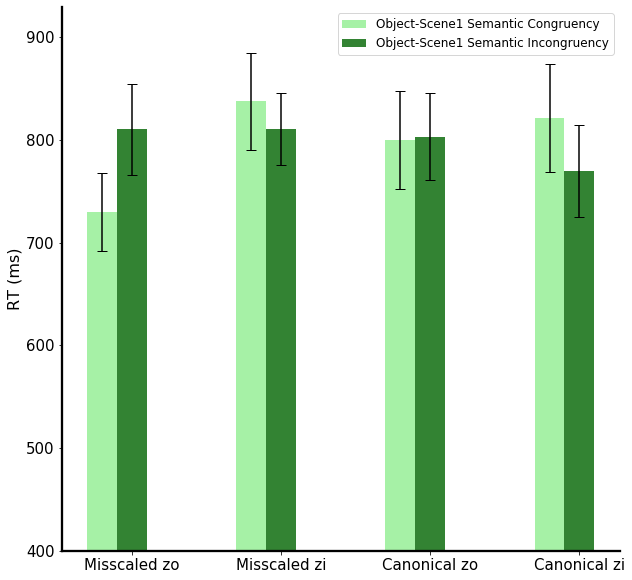

In [337]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)
#                                          Misscaled                                             Scaled
#                               zo                          zi                         zo                     zi
RT_objSemCong =   [misscaled_zo_objSemCong_RT, misscaled_zi_objSemCong_RT, scaled_zo_objSemCong_RT, scaled_zi_objSemCong_RT]
RT_objSemCong_sem = [misscaled_zo_objSemCong_RT_sem, misscaled_zi_objSemCong_RT_sem, scaled_zo_objSemCong_RT_sem, scaled_zi_objSemCong_RT_sem]

RT_objSemIncong = [misscaled_zo_objSemIncong_RT, misscaled_zi_objSemIncong_RT, scaled_zo_objSemIncong_RT, scaled_zi_objSemIncong_RT]
RT_objSemIncong_sem = [misscaled_zo_objSemIncong_RT_sem, misscaled_zi_objSemIncong_RT_sem, scaled_zo_objSemIncong_RT_sem, scaled_zi_objSemIncong_RT_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RT_objSemCong, width, color='lightgreen', label='Object-Scene1 Semantic Congruency', yerr=RT_objSemCong_sem, capsize=5, alpha=0.8)
plt.bar(x, RT_objSemIncong, width, color='darkgreen', label='Object-Scene1 Semantic Incongruency', yerr=RT_objSemIncong_sem, capsize=5, alpha=0.8)
plt.xticks(x, ['Misscaled zo', 'Misscaled zi', 'Canonical zo', 'Canonical zi'], fontsize='15')
plt.yticks(fontsize=15) 
plt.ylim(400)
plt.ylabel("RT (ms)", fontsize=16)
plt.legend(loc=0, fontsize=12)
plt.show()

In [338]:
# dfs: objSemCong --> scene2SemCong(0,1)
ms_zo_objSemCong_s2cong_CO = misscaled_zo_objSemCong_CO.loc[misscaled_zo_objSemCong_CO["scene2SemCong"]==1]
ms_zo_objSemCong_s2incong_CO = misscaled_zo_objSemCong_CO.loc[misscaled_zo_objSemCong_CO["scene2SemCong"]==0]
ms_zi_objSemCong_s2cong_CO = misscaled_zi_objSemCong_CO.loc[misscaled_zi_objSemCong_CO["scene2SemCong"]==1]
ms_zi_objSemCong_s2incong_CO = misscaled_zi_objSemCong_CO.loc[misscaled_zi_objSemCong_CO["scene2SemCong"]==0]

s_zo_objSemCong_s2cong_CO = scaled_zo_objSemCong_CO.loc[scaled_zo_objSemCong_CO["scene2SemCong"]==1]
s_zo_objSemCong_s2incong_CO = scaled_zo_objSemCong_CO.loc[scaled_zo_objSemCong_CO["scene2SemCong"]==0]
s_zi_objSemCong_s2cong_CO = scaled_zi_objSemCong_CO.loc[scaled_zi_objSemCong_CO["scene2SemCong"]==1]
s_zi_objSemCong_s2incong_CO = scaled_zi_objSemCong_CO.loc[scaled_zi_objSemCong_CO["scene2SemCong"]==0]

# RT 
ms_zo_objSemCong_s2cong_CO_RT = np.mean(np.array(ms_zo_objSemCong_s2cong_CO['RT']))
ms_zo_objSemCong_s2incong_CO_RT = np.mean(np.array(ms_zo_objSemCong_s2incong_CO['RT']))
ms_zi_objSemCong_s2cong_CO_RT = np.mean(np.array(ms_zi_objSemCong_s2cong_CO['RT']))
ms_zi_objSemCong_s2incong_CO_RT = np.mean(np.array(ms_zo_objSemCong_s2cong_CO['RT']))

s_zo_objSemCong_s2cong_CO_RT = np.mean(np.array(s_zo_objSemCong_s2cong_CO['RT']))
s_zo_objSemCong_s2incong_CO_RT = np.mean(np.array(s_zo_objSemCong_s2incong_CO['RT']))
s_zi_objSemCong_s2cong_CO_RT = np.mean(np.array(s_zi_objSemCong_s2cong_CO['RT']))
s_zi_objSemCong_s2incong_CO_RT = np.mean(np.array(s_zi_objSemCong_s2incong_CO['RT']))

# RT sem
ms_zo_objSemCong_s2cong_CO_RT_sem = sem(np.array(ms_zo_objSemCong_s2cong_CO['RT']))
ms_zo_objSemCong_s2incong_CO_RT_sem = sem(np.array(ms_zo_objSemCong_s2incong_CO['RT']))
ms_zi_objSemCong_s2cong_CO_RT_sem = sem(np.array(ms_zi_objSemCong_s2cong_CO['RT']))
ms_zi_objSemCong_s2incong_CO_RT_sem = sem(np.array(ms_zi_objSemCong_s2incong_CO['RT']))

s_zo_objSemCong_s2cong_CO_RT_sem = sem(np.array(s_zo_objSemCong_s2cong_CO['RT']))
s_zo_objSemCong_s2incong_CO_RT_sem = sem(np.array(s_zo_objSemCong_s2incong_CO['RT']))
s_zi_objSemCong_s2cong_CO_RT_sem = sem(np.array(s_zi_objSemCong_s2cong_CO['RT']))
s_zi_objSemCong_s2incong_CO_RT_sem = sem(np.array(s_zi_objSemCong_s2incong_CO['RT']))

In [339]:
# dfs: objSemIncong --> scene2SemCong(0,1)
ms_zo_objSemIncong_s2cong_CO = misscaled_zo_objSemIncong_CO.loc[misscaled_zo_objSemIncong_CO["scene2SemCong"]==1]
ms_zo_objSemIncong_s2incong_CO = misscaled_zo_objSemIncong_CO.loc[misscaled_zo_objSemIncong_CO["scene2SemCong"]==0]
ms_zi_objSemIncong_s2cong_CO = misscaled_zi_objSemIncong_CO.loc[misscaled_zi_objSemIncong_CO["scene2SemCong"]==1]
ms_zi_objSemIncong_s2incong_CO = misscaled_zi_objSemIncong_CO.loc[misscaled_zi_objSemIncong_CO["scene2SemCong"]==0]

s_zo_objSemIncong_s2cong_CO = scaled_zo_objSemIncong_CO.loc[scaled_zo_objSemIncong_CO["scene2SemCong"]==1]
s_zo_objSemIncong_s2incong_CO = scaled_zo_objSemIncong_CO.loc[scaled_zo_objSemIncong_CO["scene2SemCong"]==0]
s_zi_objSemIncong_s2cong_CO = scaled_zi_objSemIncong_CO.loc[scaled_zi_objSemIncong_CO["scene2SemCong"]==1]
s_zi_objSemIncong_s2incong_CO = scaled_zi_objSemIncong_CO.loc[scaled_zi_objSemIncong_CO["scene2SemCong"]==0]

# RT 
ms_zo_objSemIncong_s2cong_CO_RT = np.mean(np.array(ms_zo_objSemIncong_s2cong_CO['RT']))
ms_zo_objSemIncong_s2incong_CO_RT = np.mean(np.array(ms_zo_objSemIncong_s2incong_CO['RT']))
ms_zi_objSemIncong_s2cong_CO_RT = np.mean(np.array(ms_zi_objSemIncong_s2cong_CO['RT']))
ms_zi_objSemIncong_s2incong_CO_RT = np.mean(np.array(ms_zo_objSemIncong_s2cong_CO['RT']))

s_zo_objSemIncong_s2cong_CO_RT = np.mean(np.array(s_zo_objSemIncong_s2cong_CO['RT']))
s_zo_objSemIncong_s2incong_CO_RT = np.mean(np.array(s_zo_objSemIncong_s2incong_CO['RT']))
s_zi_objSemIncong_s2cong_CO_RT = np.mean(np.array(s_zi_objSemIncong_s2cong_CO['RT']))
s_zi_objSemIncong_s2incong_CO_RT = np.mean(np.array(s_zi_objSemIncong_s2incong_CO['RT']))

# RT sem
ms_zo_objSemIncong_s2cong_CO_RT_sem = sem(np.array(ms_zo_objSemIncong_s2cong_CO['RT']))
ms_zo_objSemIncong_s2incong_CO_RT_sem = sem(np.array(ms_zo_objSemIncong_s2incong_CO['RT']))
ms_zi_objSemIncong_s2cong_CO_RT_sem = sem(np.array(ms_zi_objSemIncong_s2cong_CO['RT']))
ms_zi_objSemIncong_s2incong_CO_RT_sem = sem(np.array(ms_zi_objSemIncong_s2incong_CO['RT']))

s_zo_objSemIncong_s2cong_CO_RT_sem = sem(np.array(s_zo_objSemIncong_s2cong_CO['RT']))
s_zo_objSemIncong_s2incong_CO_RT_sem = sem(np.array(s_zo_objSemIncong_s2incong_CO['RT']))
s_zi_objSemIncong_s2cong_CO_RT_sem = sem(np.array(s_zi_objSemIncong_s2cong_CO['RT']))
s_zi_objSemIncong_s2incong_CO_RT_sem = sem(np.array(s_zi_objSemIncong_s2incong_CO['RT']))

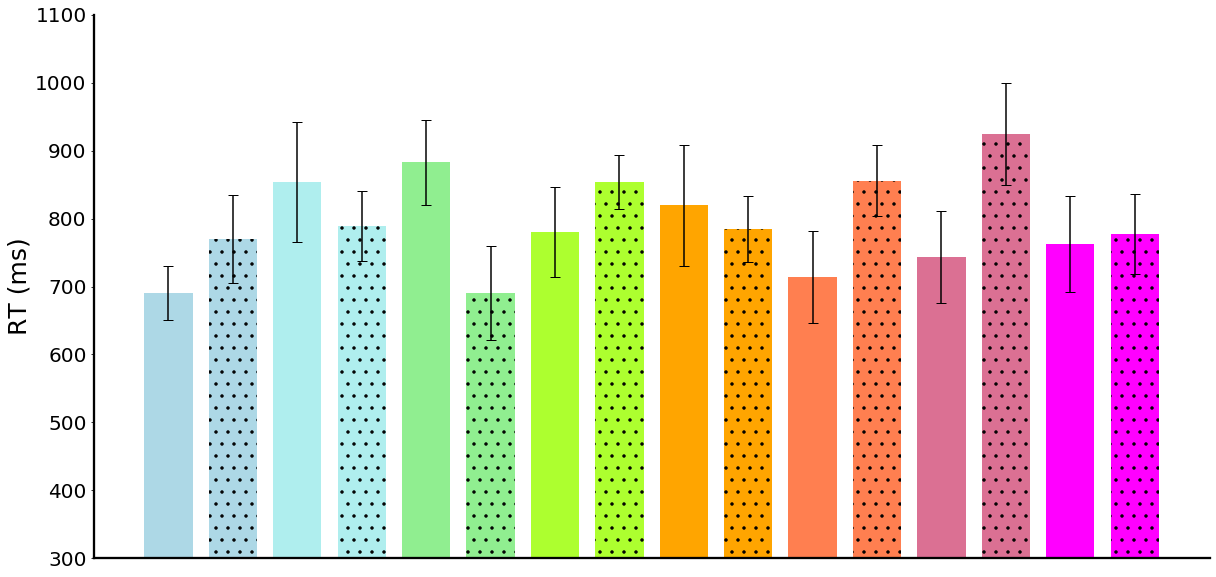

In [340]:
fig, ax = plt.subplots(figsize=[20, 10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(1)

width = 0.15

plt.bar(x-3, ms_zo_objSemCong_s2cong_CO_RT, width, color='lightblue', label='misscaled,zo,objSemCong, s2cong', yerr=ms_zo_objSemCong_s2cong_CO_RT_sem, capsize=5)
plt.bar(x-2.8, ms_zo_objSemCong_s2incong_CO_RT, width, color='lightblue', label='misscaled,zo,objSemCong, s2incong', yerr=ms_zo_objSemCong_s2incong_CO_RT_sem, capsize=5, hatch='.')

plt.bar(x-2.6, ms_zo_objSemIncong_s2cong_CO_RT, width, color='paleturquoise', label='misscaled,zo,objSemIncong, s2cong', yerr=ms_zo_objSemIncong_s2cong_CO_RT_sem, capsize=5)
plt.bar(x-2.4, ms_zo_objSemIncong_s2incong_CO_RT, width, color='paleturquoise', label='misscaled,zo,objSemIncong, s2incong', yerr=ms_zo_objSemIncong_s2incong_CO_RT_sem, capsize=5, hatch='.')

plt.bar(x-2.2, ms_zi_objSemCong_s2cong_CO_RT, width, color='lightgreen', label='misscaled,zi,objSemCong, s2cong', yerr=ms_zi_objSemCong_s2cong_CO_RT_sem, capsize=5)
plt.bar(x-2, ms_zi_objSemCong_s2incong_CO_RT, width, color='lightgreen', label='misscaled,zi,objSemCong, s2incong', yerr=ms_zi_objSemCong_s2incong_CO_RT_sem, capsize=5, hatch='.')


plt.bar(x-1.8, ms_zi_objSemIncong_s2cong_CO_RT, width, color='greenyellow', label='misscaled,zi,objSemIncong, s2cong', yerr=ms_zi_objSemIncong_s2cong_CO_RT_sem, capsize=5)
plt.bar(x-1.6, ms_zi_objSemIncong_s2incong_CO_RT, width, color='greenyellow', label='misscaled,zi,objSemIncong, s2incong', yerr=ms_zi_objSemIncong_s2incong_CO_RT_sem, capsize=5, hatch='.')



plt.bar(x-1.4, s_zo_objSemCong_s2cong_CO_RT, width, color='orange', label='scaled,zo,objSemCong, s2cong', yerr=s_zo_objSemCong_s2cong_CO_RT_sem, capsize=5)
plt.bar(x-1.2, s_zo_objSemCong_s2incong_CO_RT, width, color='orange', label='scaled,zo,objSemCong, s2incong', yerr=s_zo_objSemCong_s2incong_CO_RT_sem, capsize=5, hatch='.')

plt.bar(x-1, s_zo_objSemIncong_s2cong_CO_RT, width, color='coral', label='scaled,zo,objSemIncong, s2cong', yerr=s_zo_objSemIncong_s2cong_CO_RT_sem, capsize=5)
plt.bar(x-0.8, s_zo_objSemIncong_s2incong_CO_RT, width, color='coral', label='scaled,zo,objSemIncong, s2incong', yerr=s_zo_objSemIncong_s2incong_CO_RT_sem, capsize=5, hatch='.')

plt.bar(x-0.6, s_zi_objSemCong_s2cong_CO_RT, width, color='palevioletred', label='scaled,zi,objSemCong, s2cong', yerr=s_zi_objSemCong_s2cong_CO_RT_sem, capsize=5)
plt.bar(x-0.4, s_zi_objSemCong_s2incong_CO_RT, width, color='palevioletred', label='scaled,zi,objSemCong, s2incong', yerr=s_zi_objSemCong_s2incong_CO_RT_sem, capsize=5, hatch='.')


plt.bar(x-0.2, s_zi_objSemIncong_s2cong_CO_RT, width, color='magenta', label='scaled,zi,objSemIncong, s2cong', yerr=s_zi_objSemIncong_s2cong_CO_RT_sem, capsize=5)
plt.bar(x, s_zi_objSemIncong_s2incong_CO_RT, width, color='magenta', label='scaled,zi,objSemIncong, s2incong', yerr=s_zi_objSemIncong_s2incong_CO_RT_sem, capsize=5, hatch='.')


#                                                  Misscaled                                                       Scaled
#                                      zo                             zi                             zo                             zi
# RT_objSemCong_s2cong =   [ms_zo_objSemCong_s2cong_CO_RT,   ms_zi_objSemCong_s2cong_CO_RT,   s_zo_objSemCong_s2cong_CO_RT,    s_zi_objSemCong_s2cong_CO_RT]
# yerr_RT_objSemCong_s2cong =  [ms_zo_objSemCong_s2cong_CO_RT_sem,   ms_zi_objSemCong_s2cong_CO_RT_sem,   s_zo_objSemCong_s2cong_CO_RT_sem,    s_zi_objSemCong_s2cong_CO_RT_sem]

# RT_objSemCong_s2incong = [ms_zo_objSemCong_s2incong_CO_RT,   ms_zi_objSemCong_s2incong_CO_RT,   s_zo_objSemCong_s2incong_CO_RT,    s_zi_objSemCong_s2incong_CO_RT]
# yerr_RT_objSemCong_s2incong = [ms_zo_objSemCong_s2incong_CO_RT_sem,   ms_zi_objSemCong_s2incong_CO_RT_sem,   s_zo_objSemCong_s2incong_CO_RT_sem,    s_zi_objSemCong_s2incong_CO_RT_sem]


# RT_objSemIncong_s2cong =   [ms_zo_objSemIncong_s2cong_CO_RT,   ms_zi_objSemIncong_s2cong_CO_RT,   s_zo_objSemIncong_s2cong_CO_RT,    s_zi_objSemIncong_s2cong_CO_RT]
# yerr_RT_objSemIncong_s2cong =  [ms_zo_objSemIncong_s2cong_CO_RT_sem,   ms_zi_objSemIncong_s2cong_CO_RT_sem,   s_zo_objSemIncong_s2cong_CO_RT_sem,    s_zi_objSemIncong_s2cong_CO_RT_sem]

# RT_objSemIncong_s2incong = [ms_zo_objSemIncong_s2incong_CO_RT,   ms_zi_objSemIncong_s2incong_CO_RT,   s_zo_objSemIncong_s2incong_CO_RT,    s_zi_objSemIncong_s2incong_CO_RT]
# yerr_RT_objSemIncong_s2incong = [ms_zo_objSemIncong_s2incong_CO_RT_sem,   ms_zi_objSemIncong_s2incong_CO_RT_sem,   s_zo_objSemIncong_s2incong_CO_RT_sem,    s_zi_objSemIncong_s2incong_CO_RT_sem]





# plot data in grouped manner of bar type
# plt.bar(x-0.6, RT_objSemCong_s2cong, width, color='darkblue', label='Object-Scene1 Semantic Congruency; Scene1-Scene2 Semantic Congruency', yerr=yerr_RT_objSemCong_s2cong, capsize=5)
# plt.bar(x-0.4, RT_objSemCong_s2incong, width, color='lightblue', label='Object-Scene1 Semantic Congruency; Scene1-Scene2 Semantic Incongruency', yerr=yerr_RT_objSemCong_s2incong, capsize=5)

# plt.bar(x-0.2, RT_objSemIncong_s2cong, width, color='darkgreen', label='Object-Scene1 Semantic Incongruency; Scene1-Scene2 Semantic Congruency', yerr=yerr_RT_objSemIncong_s2cong, capsize=5)
# plt.bar(x, RT_objSemIncong_s2incong, width, color='lightgreen', label='Object-Scene1 Semantic Incongruency; Scene1-Scene2 Semantic Incongruency', yerr=yerr_RT_objSemIncong_s2incong, capsize=5)


# plt.xticks(x, ['Misscaled zo','Misscaled zi', 'Canonical zo', 'Canonical zi'], fontsize='15')



plt.ylim(300,1100)
# plt.yticks(np.arange(0.4, 1.1, 0.1))
plt.yticks(fontsize=20) 
plt.ylabel("RT (ms)", fontsize=25)
plt.xticks([])
# legend = ax.legend(loc='upper center', shadow=True, fontsize=20)
# legend.get_frame().set_facecolor('white')
plt.show()


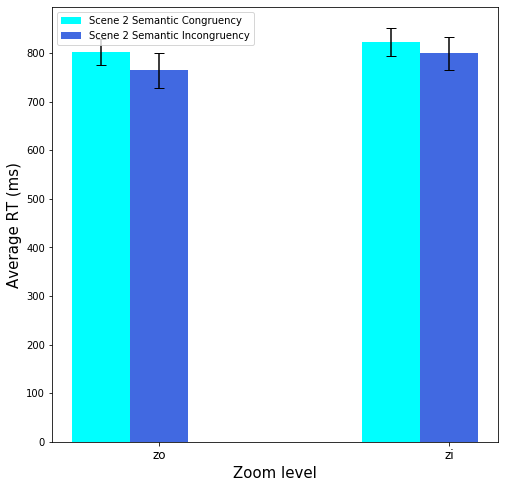

In [341]:
plt.figure(figsize=[8,8])
x = np.arange(2)

#                                   zo                          zi
RT_scene2SemCong =   [zo_scene2SemCong_RT, zi_scene2SemCong_RT]
RT_scene2SemCong_sem = [zo_scene2SemCong_RT_sem, zi_scene2SemCong_RT_sem]

RT_scene2SemIncong = [zo_scene2SemIncong_RT, zi_scene2SemIncong_RT]
RT_scene2SemIncong_sem = [zo_scene2SemIncong_RT_sem, zi_scene2SemIncong_RT_sem]

width = 0.2

# plt.ylim(900,1200)
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RT_scene2SemCong, width, color='cyan', label='Scene 2 Semantic Congruency', yerr=RT_scene2SemCong_sem, capsize=5)
plt.bar(x, RT_scene2SemIncong, width, color='royalblue', label='Scene 2 Semantic Incongruency', yerr=RT_scene2SemIncong_sem, capsize=5)
plt.xticks(x, ['zo', 'zi'], fontsize='12')
plt.xlabel("Zoom level", fontsize=15)
plt.ylabel("Average RT (ms)", fontsize=15)
plt.legend(loc=2, fontsize=10)
plt.show()

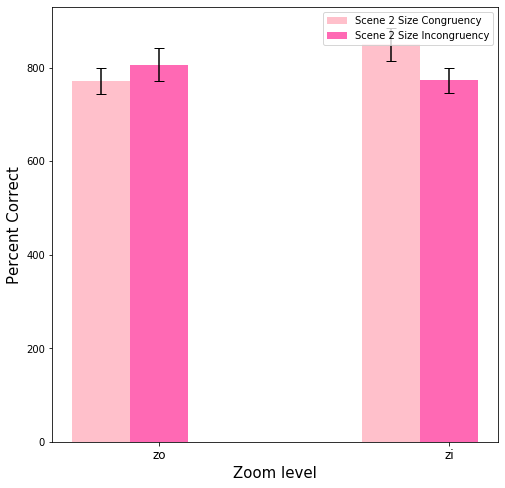

In [342]:
plt.figure(figsize=[8,8])
x = np.arange(2)

#                                   zo                          zi
RT_scene2SizeCong =   [zo_scene2SizeCong_RT, zi_scene2SizeCong_RT]
RT_scene2SizeCong_sem = [zo_scene2SizeCong_RT_sem, zi_scene2SizeCong_RT_sem]

RT_scene2SizeIncong = [zo_scene2SizeIncong_RT, zi_scene2SizeIncong_RT]
RT_scene2SizeIncong_sem = [zo_scene2SizeIncong_RT_sem, zi_scene2SizeIncong_RT_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RT_scene2SizeCong, width, color='pink', label='Scene 2 Size Congruency', yerr=RT_scene2SizeCong_sem, capsize=5)
plt.bar(x, RT_scene2SizeIncong, width, color='hotpink', label='Scene 2 Size Incongruency', yerr=RT_scene2SizeIncong_sem, capsize=5)
plt.xticks(x, ['zo', 'zi'], fontsize='12')
plt.xlabel("Zoom level", fontsize=15)
plt.ylabel("Percent Correct", fontsize=15)
plt.legend(loc=1, fontsize=10)
plt.show()

In [343]:
RTs_correctOnly = list(final_data_correctOnly['RT']) 

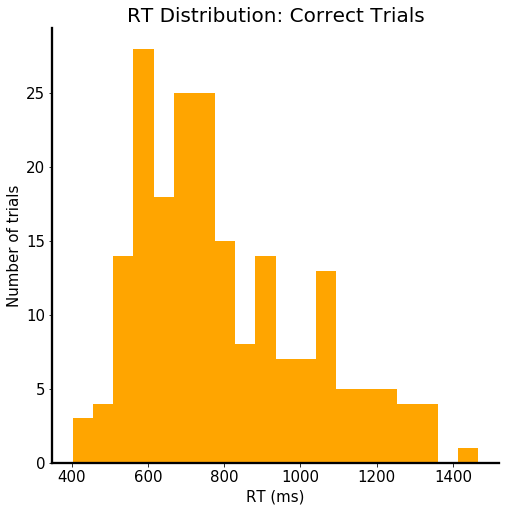

In [344]:

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)

ax.spines['top'].set_visible(False)



for axis in ['bottom','left']:

    ax.spines[axis].set_linewidth(2.3)

plt.hist(np.array(RTs_correctOnly), color='orange', bins=20)
plt.title('RT Distribution: Correct Trials', fontsize=20)
plt.xlabel('RT (ms)', fontsize=15)
plt.ylabel('Number of trials', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Inverse Efficiency Score 

RT/acc

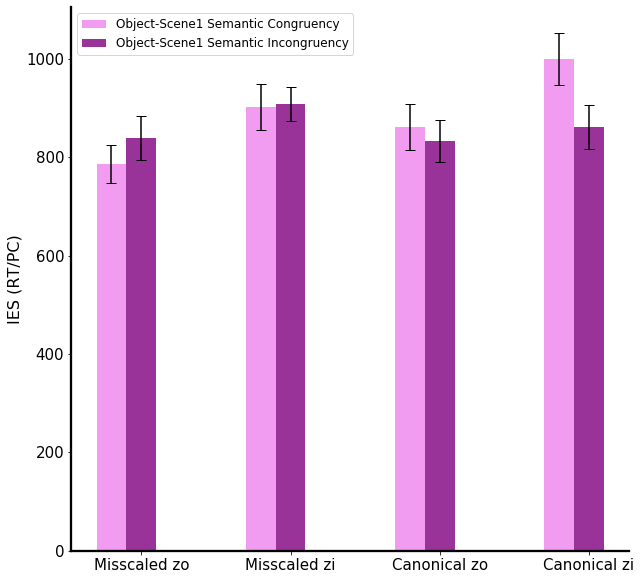

In [345]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

IES_objSemCong =   [misscaled_zo_objSemCong_RT/misscaled_zo_objSemCong_acc, misscaled_zi_objSemCong_RT/misscaled_zi_objSemCong_acc, scaled_zo_objSemCong_RT/scaled_zo_objSemCong_acc, scaled_zi_objSemCong_RT/scaled_zi_objSemCong_acc]
IES_objSemCong_sem = [misscaled_zo_objSemCong_RT_sem/misscaled_zo_objSemCong_sem, misscaled_zi_objSemCong_RT_sem/misscaled_zi_objSemCong_sem, scaled_zo_objSemCong_RT_sem/scaled_zo_objSemCong_sem, scaled_zi_objSemCong_RT_sem/scaled_zi_objSemCong_sem]

IES_objSemIncong = [misscaled_zo_objSemIncong_RT/misscaled_zo_objSemIncong_acc, misscaled_zi_objSemIncong_RT/misscaled_zi_objSemIncong_acc, scaled_zo_objSemIncong_RT/scaled_zo_objSemIncong_acc, scaled_zi_objSemIncong_RT/scaled_zi_objSemIncong_acc]
IES_objSemIncong_sem = [misscaled_zo_objSemIncong_RT_sem/misscaled_zo_objSemIncong_sem, misscaled_zi_objSemIncong_RT_sem/misscaled_zi_objSemIncong_sem, scaled_zo_objSemIncong_RT_sem/scaled_zo_objSemIncong_sem, scaled_zi_objSemIncong_RT_sem/scaled_zi_objSemIncong_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, IES_objSemCong, width, color='violet', label='Object-Scene1 Semantic Congruency', yerr=RT_objSemCong_sem, capsize=5, alpha=0.8)
plt.bar(x, IES_objSemIncong, width, color='purple', label='Object-Scene1 Semantic Incongruency', yerr=RT_objSemIncong_sem, capsize=5, alpha=0.8)
plt.xticks(x, ['Misscaled zo', 'Misscaled zi', 'Canonical zo', 'Canonical zi'], fontsize='15')
plt.yticks(fontsize=15) 
# plt.ylim(900)
plt.ylabel("IES (RT/PC)", fontsize=16)
plt.legend(loc=0, fontsize=12)
plt.show()